# Deep Learning Assignment 4: CNNs for Face Identification 

We will perform face identification using a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class calssification problem where we have training/testing images for a set of subjects (classes). In 2014, researchers were able to surpass human accuracy in facial identification tasks using CNN models (along with advanced deep learning techniques)! 

We will observe the performance of a traditional face identification method, [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface). We will then build a CNN model in order to surpass the accuracy of the traditional Eigenfaces technique. In the process, we will learn about the great power of CNNs!

### Requirements

1. Python 3.6
2. `pip install numpy`
3. `pip install sklearn`
4. `pip install matplotlib`
5. `pip install tensorflow==2.0.0`


### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)


In [25]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

Let's start by downloading and setting up a subset of the aligned and segmented version of the LFW dataset. We will only get subjects with at least 20 corresponding images. We will also get the grayscale versions of the images. This may take a few minutes . . .

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

The downloaded `data_x` will be the flattened vector representation of the images. 

We will reshape the vector respresentations back into the original grayscale images and store the images back in `data_x`.

In [3]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images 
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 26
Number of images: 1875

data_x shape: (1875, 62, 47, 1)
data_y shape: (1875,)


As we can see, the dataset is made up of `3023` images of `62` subjects (or classes). 

Each image is a `62x47x1`-dimensional matrix containing 8-bit (0-255) grayscale pixel values.

Let's visualize a few of the grayscale images.

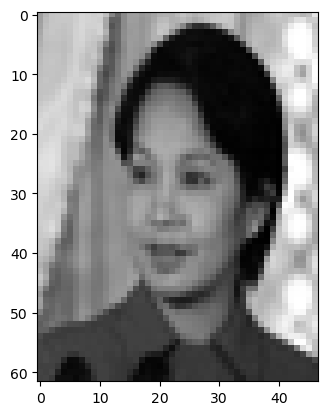

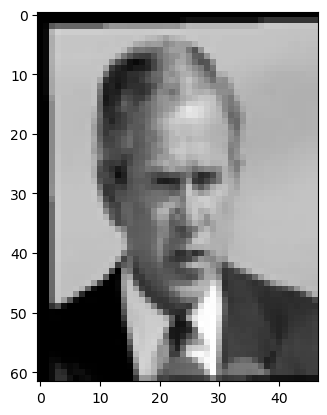

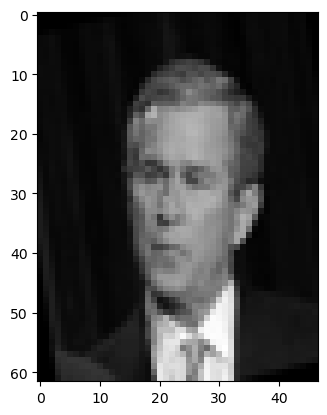

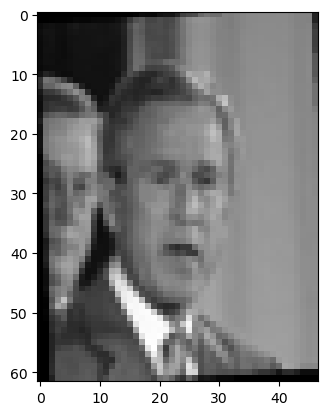

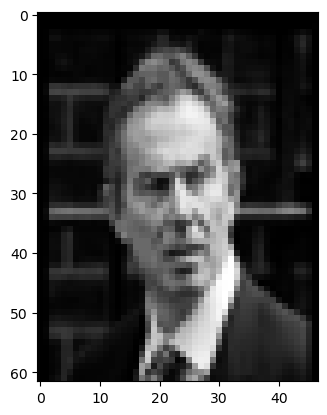

In [4]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

Now, let's split the dataset into train and test sets so we can perform face identification!

We will perform a `90/10` stratified split. This means that `90%` of each subject's images are placed in the train set, while the remaining `10%` of each subject's images are placed into the test set. 

In [5]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (1687, 62, 47, 1)
train_y shape: (1687,)

test_x shape: (188, 62, 47, 1)
test_y shape: (188,)


### Eigenfaces Overview

Eigenfaces is a face identification technique proposed in 1987. It was a very popular algorithm through the 1990's and is still used today as a baseline algorithm when gauging the performance of proposed face identification techniques. Eigenfaces is used to extract features from facial images. Such facial features are more useful in identification tasks than the corresponding oringinal images. The facial features can then be used for identification by being classified by a multi-class classifier, such a logistic regression model. 

### Eigenfaces Details

Eigenfaces is a Principcal Componet Analysis (PCA)-based dimensionality-reduction technique. Eigenfaces deals with the flattened vector representations of the face images. 

We give the vector representation of the training images as input to the algorithm. The output of the algoirthm is a set of Eigenfaces (vectors) which we can use to project vector representations of images into a lower-dimensional space which (hopefully) encode important facial features. 

Since the lower-dimensional space captures important facial features, Eigenfaces is used as a feature extraction technique. Given a facial image, we can reshape the image into a vector. Using the Eigenfaces, we reduce the dimensionality of the original vector into a vector which is more useful in identifying its corresponging subject. Therefore, we will use the Eigenfaces to extract facial features. Then, we will use a simple logistic regression classifier to classify the resulting facial features.

Let's start by flattening the training facial images. Then we will continue by computing the Eigenfaces which capture `95%` of the variance of the original dataset.

In [6]:
# flatten images 
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2])) 
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2])) 

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (1687, 2914)
Eigenfaces shape: (238, 2914)


As we see, if we flatten the training images to gather their vector representations, we recieve `2720` vectors of size `2914`. We also see that we have found `173` Eigenfaces vectors of size `2914`.

If we reshape the set of Eigenfaces to the shape of the original images, they reveal intesting ghost faces (i.e. "Eigenfaces").

Let's view the first `10` Eigenfaces.

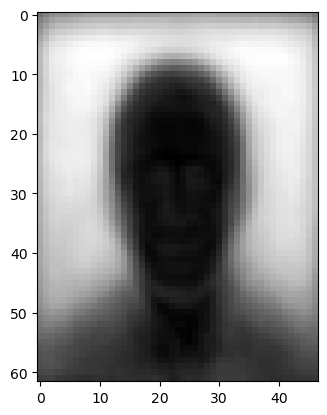

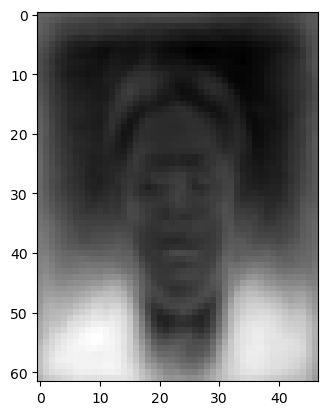

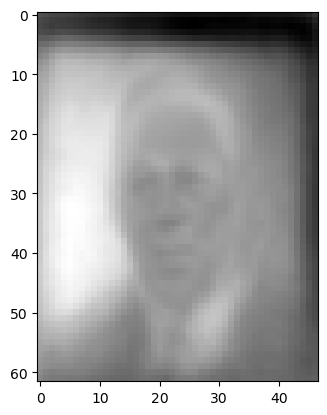

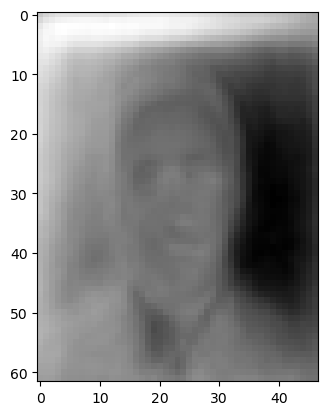

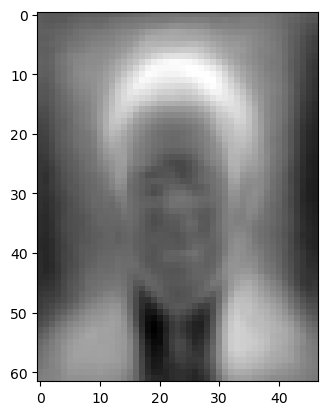

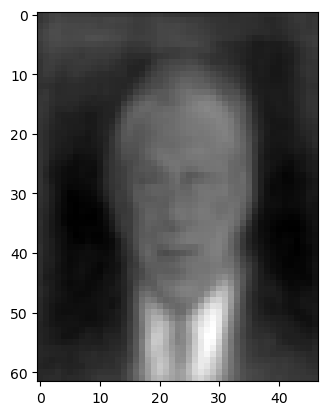

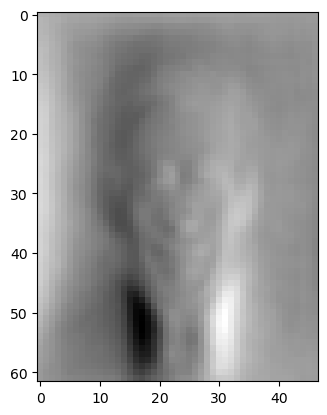

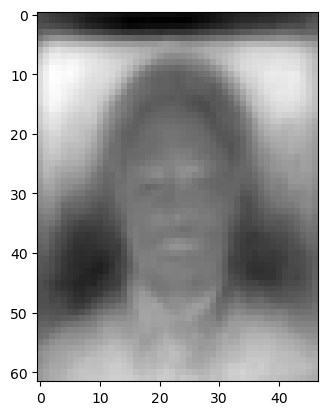

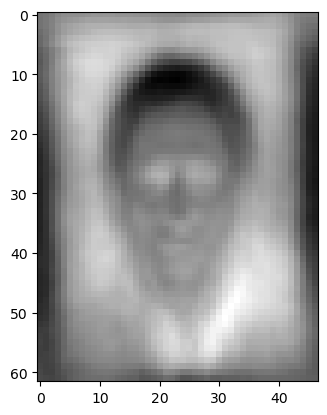

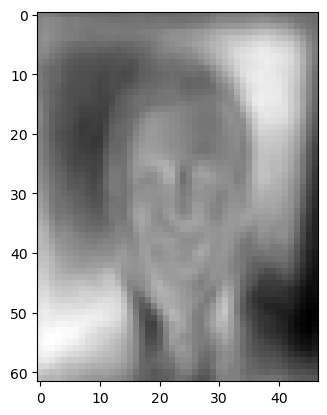

In [7]:
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

Spooky!

Now, let's use the Eigenfaces to extract facial features from the training and test set vectors. Since we have `173` Eigenfaces, we will reduce the dimensionality of the `2914`-dimensional train/test vectors to `173`-dimensional train/test feature vectors.

In [8]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (1687, 2914)
Training features shape: (1687, 238)
Testing vectors shape: (188, 2914)
Testing features shape: (188, 238)


Great! Now that we have extracted facial features from the train and testing set, let's perform facial identification using a simple logistic regression model!

In [9]:
# specify the input size of the feature vectors
features = Input((train_features_x.shape[1],))
# a single fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(features)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
logistic_regression = Model(inputs=features, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(logistic_regression.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 238)]             0         
                                                                 
 dense (Dense)               (None, 26)                6214      
                                                                 
 activation (Activation)     (None, 26)                0         
                                                                 
Total params: 6,214
Trainable params: 6,214
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights = {i:class_weights[i] for i in range(class_weights.shape[0])}

# train model, verbose set to 0 to supress output, wait a moment for training to complete
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y), 
                        class_weight=class_weights, 
                        epochs=75, batch_size=128, verbose=0)

# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)
print("\nTraining accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

6/6 [==============================] - 0s 1ms/step

Training accuracy using Eigenfaces and logistic regression model: 0.6040308239478364
Testing accuracy using Eigenfaces and logistic regression model: 0.42021276595744683


# Your turn!

### Sample CNN Model
The Eigenfaces and logistic regression model doesn't perform that well on the unseen test set. Let's see how a simple CNN model compares.

Rather than dealing with vectors, we will begin working with the grayscale images directly. 

Remember that a CNN learns convolution filters which extract the most useful features. Then, a small neural network at the end of the CNN architecture performs the multi-class classification. Therefore, the CNN will make things less complex for us as the CNN will learn to perform both feature extraction and classification! 

<b> Complete the section below</b>

In [28]:
# COMPLETE THE CODE ACCORDING TO THE COMMENTS

# specify the input size of the images
images = Input((train_x.shape[1], train_x.shape[2], 1,))
# a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32, (9, 9), padding='valid', input_shape=(62, 47, 1))(images)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2, 2))(x)
# another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64, (11, 11), padding='valid')(x)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2, 2))(x)
# flatten extracted features to form feature vector
x = Flatten()(x)
# a drop out layer for regularization (25% probability)
x = Dropout(.25)(x)
# first fully-connected layer to map the features to vectors of size 256
x = Dense(256)(x)
# anoter drop out layer for regularization (25% probability)
x = Dropout(.25)(x)
# a second fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(x)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation('softmax')(x)

# create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(sample_cnn.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 54, 39, 32)        2624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 27, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 17, 9, 64)         247872    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0   

In [29]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
class_weights = {i:class_weights[i] for i in range(class_weights.shape[0])}

# train model
sample_cnn.fit(x=train_x, y=train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))

print("The sample CNN model beat the Eigenfaces and logistic regression model! :)")
print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Epoch 1/15
27/27 [==============================] - 1s 13ms/step - loss: 3.2750 - acc: 0.0178 - val_loss: 3.2578 - val_acc: 0.0319
Epoch 2/15
27/27 [==============================] - 0s 9ms/step - loss: 3.2580 - acc: 0.0296 - val_loss: 3.3214 - val_acc: 0.0160
Epoch 3/15
27/27 [==============================] - 0s 9ms/step - loss: 3.1600 - acc: 0.0439 - val_loss: 3.0623 - val_acc: 0.1117
Epoch 4/15
27/27 [==============================] - 0s 9ms/step - loss: 2.8025 - acc: 0.0972 - val_loss: 2.5956 - val_acc: 0.1809
Epoch 5/15
27/27 [==============================] - 0s 9ms/step - loss: 2.4800 - acc: 0.1784 - val_loss: 2.4175 - val_acc: 0.2553
Epoch 6/15
27/27 [==============================] - 0s 9ms/step - loss: 2.2928 - acc: 0.2152 - val_loss: 2.1648 - val_acc: 0.3351
Epoch 7/15
27/27 [==============================] - 0s 9ms/step - loss: 2.0699 - acc: 0.2644 - val_loss: 2.1599 - val_acc: 0.2819
Epoch 8/15
27/27 [==============================] - 0s 9ms/step - loss: 1.9377 - acc: 0.3

## More tasks

2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different 
3. Build a fourth CNN model which achieves >70% test accuracy 
4. Display a correctly identified image and a training image corresponding to the correct training subject 
5. Display a incorrectly identified image and a training image corresponding to the correct training subject 

### Rubric

1. Complete the sample CNN as specified by the comments (2 pts.)
2. Build three CNN models which surpass the traditional Eigenface method test accuracy. In each model use different architectures and optimizers. Points will be not be awarded if models architectures are not sufficiently different (3 pts.)
3. Build a fourth CNN model which achieves >70% test accuracy (3 pts.)
4. Display a correctly identified image and a training image corresponding to the correct training subject (1 pts.)
5. Display a incorrectly identified image and a training image corresponding to the correct training subject (1 pts.)

Feel free to use the code above to get started on your own models!

In [13]:
cnn_1 = Sequential([
    Conv2D(32, (5, 5), input_shape=(62, 47, 1), activation='tanh'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, (9, 9), input_shape=(54, 29, 32), activation='tanh'),
    MaxPool2D(pool_size=(1, 1)),
    Conv2D(128, (11, 11), input_shape=(21, 13, 64), activation='tanh'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(.2),
    Dense(512, activation='tanh'),
    Dropout(.2),
    Dense(num_subjects, activation='softmax')
])

cnn_1.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

history_1 = cnn_1.fit(
    x=train_x, 
    y=train_y,
    validation_data=(test_x, test_y),
    class_weight=class_weights, 
    epochs=15,
    verbose=0
)

# evaluate model, get train/test accuracy
test_pred = np.argmax(cnn_1.predict(test_x), axis=1)
print(f"\nCNN_1 Testing accuracy: {accuracy_score(test_y, test_pred)}")
print(f"\nEigenfaces/Logistic Regression Testing accuracy: {accuracy_score(test_y, test_eig_pred)}")

6/6 [==============================] - 0s 2ms/step

CNN_1 Testing accuracy: 0.6542553191489362

Eigenfaces/Logistic Regression Testing accuracy: 0.39893617021276595


In [15]:
cnn_2 = Sequential([
    Conv2D(32, (7, 7), input_shape=(62, 47, 1), activation='tanh'),
    Conv2D(32, (9, 9), input_shape=(56, 41, 32), activation='tanh'),
    Conv2D(32, (11, 11), input_shape=(48, 33, 32),activation='tanh'),
    MaxPool2D(pool_size=(4, 4)),
    Flatten(),
    Dense(512, activation='tanh', kernel_regularizer='l2'),
    Dense(num_subjects, activation='softmax')
])

cnn_2.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

history_2 = cnn_2.fit(
    x=train_x, 
    y=train_y,
    validation_data=(test_x, test_y),
    class_weight=class_weights, 
    epochs=15,
    verbose=0
)

# evaluate model, get train/test accuracy
test_pred = np.argmax(cnn_2.predict(test_x), axis=1)
print(f"\nCNN_2 Testing accuracy: {accuracy_score(test_y, test_pred)}")
print(f"\nEigenfaces/Logistic Regression Testing accuracy: {accuracy_score(test_y, test_eig_pred)}")

6/6 [==============================] - 0s 6ms/step

CNN_2 Testing accuracy: 0.723404255319149

Eigenfaces/Logistic Regression Testing accuracy: 0.39893617021276595


In [22]:
cnn_3 = Sequential([
    Conv2D(16, (5, 5), activation='tanh', input_shape=(62, 47, 1)),
    Conv2D(32, (7, 7), activation='tanh', input_shape=(58, 43, 16)),
	BatchNormalization(),
	MaxPool2D((4, 4)),
	Conv2D(16, (9, 9), activation='tanh', input_shape=(13, 9, 32)),
	BatchNormalization(),
	Flatten(),
	Dense(512, activation='tanh', kernel_regularizer='l2'),
	Dense(26, activation='softmax'),
])

cnn_3.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

history_3 = cnn_3.fit(
    x=train_x, 
    y=train_y,
    validation_data=(test_x, test_y),
    class_weight=class_weights, 
    epochs=15,
    verbose=0
)

# evaluate model, get train/test accuracy
test_pred = np.argmax(cnn_3.predict(test_x), axis=1)
print(f"\nCNN_3 Testing accuracy: {accuracy_score(test_y, test_pred)}")
print(f"\nEigenfaces/Logistic Regression Testing accuracy: {accuracy_score(test_y, test_eig_pred)}")

6/6 [==============================] - 0s 2ms/step

CNN_3 Testing accuracy: 0.8776595744680851

Eigenfaces/Logistic Regression Testing accuracy: 0.39893617021276595


In [24]:
cnn_4 = Sequential([
    Conv2D(32, (9, 9), activation='relu', input_shape=(62, 47, 1)),
	BatchNormalization(),
	Conv2D(64, (7, 7), activation='relu', input_shape=(54, 39, 32)),
	BatchNormalization(),
    MaxPool2D(pool_size=(4, 4)),
	Flatten(),
	Dense(128, activation='relu', kernel_regularizer='l2'),
	Dense(26, activation='softmax'),
])

cnn_4.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

history_4 = cnn_4.fit(
    x=train_x, 
    y=train_y,
    validation_data=(test_x, test_y),
    class_weight=class_weights, 
    epochs=15,
    verbose=0
)

# evaluate model, get train/test accuracy
test_pred = np.argmax(cnn_4.predict(test_x), axis=1)
print(f"\nCNN_4 Testing accuracy: {accuracy_score(test_y, test_pred)}")
print(f"\nCNN_4 Testing accuracy >= .70: {accuracy_score(test_y, test_pred)>=.7}")

6/6 [==============================] - 0s 2ms/step

CNN_4 Testing accuracy: 0.7712765957446809

CNN_4 Testing accuracy >= .70: True


### A correctly predicted image

1/1 [==============================] - 0s 18ms/step
(1, 26)
0 1.6683747e-05
1 3.7274447e-05
2 8.6588193e-07
3 2.4281308e-05
4 9.052596e-08
5 0.000114066876
6 0.039005555
7 0.037469376
8 0.6535865
9 0.0006229495
10 6.8577424e-07
11 6.996642e-07
12 0.0031529544
13 4.401879e-05
14 7.899464e-05
15 1.6180795e-05
16 3.0571545e-07
17 0.0013459926
18 3.0249296e-06
19 4.0505993e-06
20 5.3087723e-07
21 2.434752e-06
22 2.717731e-07
23 0.00020286563
24 0.26425296
25 1.63884e-05
---------------
Prediction: 8
Label: 8
-------------------------------------------
Image of Correctly Predicted Subject from Test set


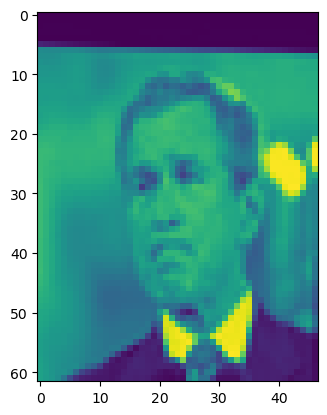

Image of Correctly Labeled Subject from Train set


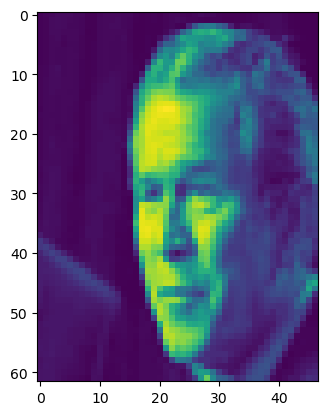

In [58]:
image_index = 29# random.choice([i for i in range(test_x.shape[0])]) # 29
pred = cnn_4.predict(test_x[image_index].reshape(1, 62, 47, 1))
print(pred.shape)
for i in range(pred.shape[1]):
    print (i,pred[0,i])
print('-'*15)
print(f"Prediction: {pred.argmax()}")
print(f"Label: {test_y[image_index]}")
print('-'*43)
print("Image of Correctly Predicted Subject from Test set")
plt.imshow(test_x[image_index].reshape(62, 47, 1))
plt.show()
print("Image of Correctly Labeled Subject from Train set")
plt.imshow(train_x[2].reshape(62, 47, 1))
plt.show()

### An incorrectly predicted image

1/1 [==============================] - 0s 18ms/step
(1, 26)
0 5.556033e-05
1 0.0015054396
2 0.08056989
3 0.027587306
4 0.025104737
5 0.0059412476
6 0.00086684304
7 0.035694
8 0.006717466
9 9.364176e-05
10 5.7756492e-06
11 0.00011549371
12 0.77211636
13 0.00069344294
14 5.215101e-05
15 0.0027803741
16 1.4127152e-06
17 0.017006036
18 0.0012948574
19 2.7164691e-05
20 3.3515553e-07
21 0.020731378
22 5.7147372e-05
23 4.9760092e-05
24 0.00032730133
25 0.00060489774
---------------
Prediction: 12
Label: 4
-------------------------------------------
Image of Incorrectly Predicted Subject from Test set


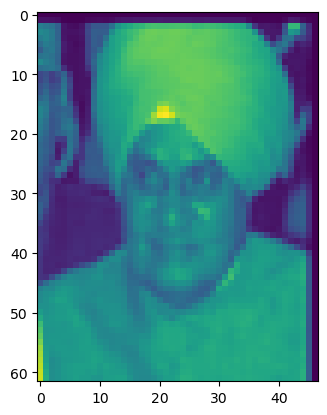

Image of Labeled Subject from Train set


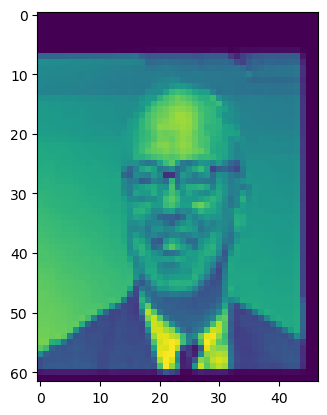

In [59]:
image_index = 88 # random.choice([i for i in range(test_x.shape[0])]) # 88
pred = cnn_4.predict(test_x[image_index].reshape(1, 62, 47, 1))
print(pred.shape)
for i in range(pred.shape[1]):
    print (i,pred[0,i])
print('-'*15)
print(f"Prediction: {pred.argmax()}")
print(f"Label: {test_y[image_index]}")
print('-'*43)
print("Image of Incorrectly Predicted Subject from Test set")
plt.imshow(test_x[image_index].reshape(62, 47, 1))
plt.show()
print("Image of Labeled Subject from Train set")
plt.imshow(train_x[22].reshape(62, 47, 1))
plt.show()